In [1]:
#  Подключаю необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [13]:
df = pd.read_csv('winequality-red.csv', sep=';')

In [14]:
#  Все хорошо?
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [26]:
#  Классы сбалансированы?
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [27]:
#  Проверяю размерность матрицы данных
df.shape

(1599, 12)

In [36]:
#  разделяю предикоторы и отклики
X = df.iloc[:, :-1].values  
y = df.iloc[:, -1].values 

In [37]:
#  разделяю на обучающую и тестовую выборку

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)  

In [57]:
#  Задаю параметры модели
from sklearn.tree import DecisionTreeClassifier

# Инициализируем модель
model = DecisionTreeClassifier(random_state=13,
                               criterion='gini',
                               # максимальная глубина дерева
                               max_depth=6,
                               max_leaf_nodes=None,
                               # минимальное число элементов в узле для разбиения (может быть долей)
                               min_samples_split=10,
                               # минимальное число элементов в листе (может быть долей)
                               min_samples_leaf=8,
                               min_impurity_decrease=0.001,
                               class_weight=None,
                               min_weight_fraction_leaf=0,                           
                               splitter='best',
                               max_features = None)
# Обучаем модель
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0, presort='deprecated',
                       random_state=13, splitter='best')

In [58]:
pd.DataFrame({'feature': df.iloc[:, :-1].columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
10,alcohol,0.423460
9,sulphates,0.145225
6,total sulfur dioxide,0.117424
1,volatile acidity,0.092231
3,residual sugar,0.046674
7,density,0.046645
0,fixed acidity,0.041607
5,free sulfur dioxide,0.033576
4,chlorides,0.024098
8,pH,0.023038


In [59]:
# Активируем поиск на решетке GridSearchCV
from sklearn.model_selection import GridSearchCV

#   Определяем тестируемые значения гиперпараметров
params_set = {
'max_depth': [3, 4, 5, 6],
'min_samples_leaf': [2, 4, 8, 16],
'min_samples_split': [8, 10, 14, 18]
}


#   Проводим 5-fold кросс-валидацию
#   Качество моделей сравниваем с помощью accuracy, так как классы сбалансрованы
grid_CV_1 = GridSearchCV(estimator=model,
       param_grid=params_set,
       scoring='balanced_accuracy',
       cv=10,
       n_jobs=-1)


#   Обучение на обучающей выборке
grid_CV_1.fit(X_train, y_train)

C:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=6,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.001,
                                              min_impurity_split=None,
                                              min_samples_leaf=8,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0,
                                              presort='deprecated',
                                              random_state=13,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'min_s

In [60]:
#   Лучший набор значений гиперпараметров

best_hyperparams = grid_CV_1.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 8}


In [61]:
# Лучшая модель
best_model = grid_CV_1.best_estimator_

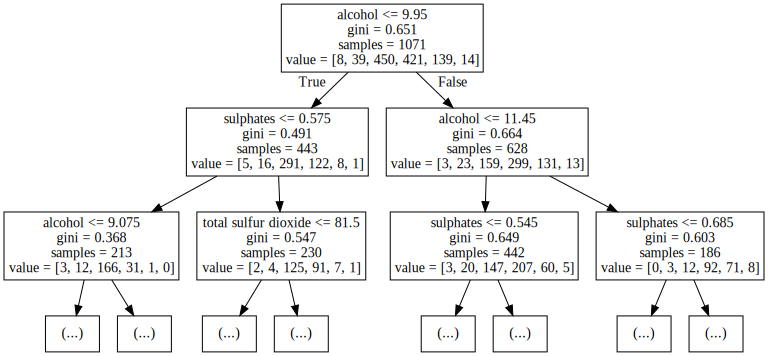

In [62]:
from graphviz import Source
from sklearn import tree
Source( tree.export_graphviz(best_model, max_depth = 2, out_file=None, feature_names=df.iloc[:, :-1].columns))

In [63]:
# Посмотрим на balanced_accuracy на тестовом множестве
test_acc = best_model.score(X_test,y_test)
print('Balanced_accuracy на тестовом множестве', test_acc)

# Построим предсказания
y_pred_test = best_model.predict(X_test)
y_pred_test

Balanced_accuracy на тестовом множестве 0.5871212121212122


array([5, 5, 6, 6, 7, 5, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 5, 5, 7, 5, 5, 6,
       5, 6, 6, 7, 6, 5, 7, 5, 5, 6, 5, 6, 5, 5, 6, 5, 6, 6, 6, 6, 6, 6,
       6, 5, 5, 6, 7, 6, 5, 6, 7, 7, 6, 6, 6, 6, 7, 5, 6, 5, 5, 6, 5, 7,
       6, 6, 5, 7, 6, 6, 5, 6, 5, 6, 6, 7, 5, 6, 6, 5, 6, 6, 6, 5, 7, 5,
       6, 6, 7, 6, 7, 6, 6, 6, 5, 7, 7, 6, 5, 5, 5, 6, 6, 5, 6, 5, 6, 6,
       7, 5, 7, 5, 6, 5, 5, 6, 7, 5, 7, 7, 6, 6, 6, 5, 5, 8, 7, 7, 5, 5,
       6, 5, 5, 6, 6, 5, 6, 6, 6, 5, 6, 5, 6, 6, 5, 7, 7, 5, 5, 6, 6, 7,
       7, 6, 5, 6, 7, 6, 7, 6, 7, 5, 6, 6, 6, 5, 6, 6, 5, 6, 5, 6, 7, 6,
       6, 7, 6, 5, 5, 5, 6, 6, 5, 6, 7, 7, 6, 7, 7, 5, 5, 7, 6, 5, 6, 7,
       6, 5, 5, 7, 6, 5, 7, 6, 6, 5, 5, 5, 6, 5, 5, 6, 7, 7, 5, 6, 5, 6,
       6, 6, 5, 5, 6, 5, 6, 7, 5, 7, 7, 6, 6, 5, 5, 5, 7, 6, 6, 6, 5, 5,
       7, 5, 5, 5, 5, 6, 7, 7, 6, 6, 7, 5, 6, 6, 6, 5, 6, 5, 5, 5, 7, 7,
       6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 7, 5, 6, 6, 5, 6,
       7, 5, 6, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 6, 6,